In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

In [34]:
T = 1000
K = 20
prices = np.linspace(0,1,K)
coef = np.random.uniform(0.5,3,T)
# coef = [np.sin(t) for t in range(T)]
conversion_probability = np.zeros((T,K))
for i in range(T):
    conversion_probability[i]=(np.ones(K)-coef[i]*prices)*(np.ones(K)-coef[i]*prices >0)

In [35]:
cost = 0
reward_sequence = conversion_probability*(prices-cost)
print(reward_sequence)
# print(np.argmax(profit_sequence.sum(axis =0)))

# estimated_profit_curve = np.random.binomial(n_customers, conversion_probability(prices))*(prices-cost)

# best_price_index = np.argmax(expected_profit_curve)
# best_price = prices[best_price_index]

[[ 0.          0.04446095  0.07258064 ... -0.         -0.
  -0.        ]
 [ 0.          0.04671191  0.08158449 ... -0.         -0.
  -0.        ]
 [ 0.          0.04629954  0.07993499 ... -0.         -0.
  -0.        ]
 ...
 [ 0.          0.04724925  0.08373383 ... -0.         -0.
  -0.        ]
 [ 0.          0.05016613  0.09540134 ...  0.18222076  0.14856147
   0.10997127]
 [ 0.          0.04905182  0.09094412 ... -0.         -0.
  -0.        ]]


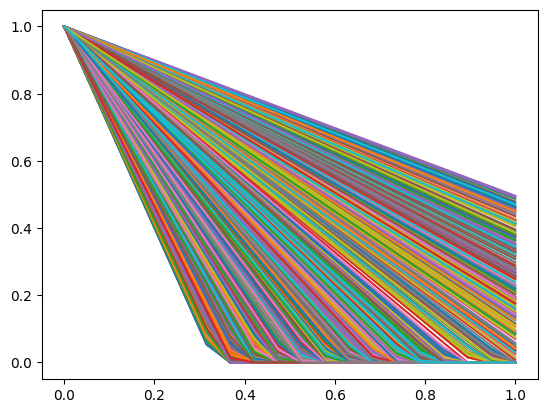

In [169]:
# plt.plot(prices,sum([expected_profit[i] for i in range(T)]))
for i in range(T):
    plt.plot(prices,conversion_probability[i])
    # plt.plot(prices,reward_sequence[i])

In [37]:
class AdversarialExpertEnvironment:
    def __init__(self, reward_sequence):
        self.reward_sequence = reward_sequence
        self.t = 0

    def round(self): # we do not need to receive a specific arm
        r_t = self.reward_sequence[self.t, :] ## we return the whole loss vector
        self.t+=1
        return r_t

In [38]:
env = AdversarialExpertEnvironment(reward_sequence)
env.t, env.round(), env.t

(0,
 array([ 0.        ,  0.04446095,  0.07258064,  0.08435906,  0.07979623,
         0.05889214,  0.02164678, -0.        , -0.        , -0.        ,
        -0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        , -0.        , -0.        , -0.        , -0.        ]),
 1)

In [166]:
# print(f'Best achievable cumulative reward: {reward_sequence.max(axis=0).sum()}')
print(f'Best achievable cumulative reward when always pulling the same arm: {reward_sequence.sum(axis=0).max()}')

Best achievable cumulative reward when always pulling the same arm: 141.22952838542665


In [40]:
best_arm = np.argmax(reward_sequence.sum(axis=0))
print(f'The best arm in hindsight is {best_arm}')

The best arm in hindsight is 5


In [41]:
clairvoyant_reward = reward_sequence[:, best_arm]
clairvoyant_reward

array([0.05889214, 0.11516624, 0.10485683, 0.11226201, 0.05774996,
       0.12990371, 0.09117506, 0.14183017, 0.10623475, 0.06863626,
       0.09130764, 0.0981721 , 0.20837981, 0.13986099, 0.19173903,
       0.10976641, 0.22247053, 0.17750327, 0.07550881, 0.22042393,
       0.11094165, 0.14064932, 0.14645048, 0.15302063, 0.09436828,
       0.08000315, 0.22559507, 0.08910608, 0.16138267, 0.20939256,
       0.07001059, 0.1515624 , 0.19605925, 0.11214619, 0.09512242,
       0.0700434 , 0.07263107, 0.1489323 , 0.22573247, 0.18907692,
       0.1682584 , 0.1773871 , 0.14580673, 0.15018606, 0.05825815,
       0.10476882, 0.17868771, 0.10810021, 0.10118489, 0.15866317,
       0.07389862, 0.21321656, 0.09821163, 0.16930989, 0.20475884,
       0.14779948, 0.222675  , 0.21253629, 0.16029005, 0.18407801,
       0.06376699, 0.16416539, 0.06832754, 0.22005575, 0.11991137,
       0.10472489, 0.10217742, 0.10145019, 0.22224348, 0.10097719,
       0.22076575, 0.07219706, 0.2113366 , 0.09607884, 0.17650

In [42]:
class HedgeAgent:
    def __init__(self, K, learning_rate):
        self.K = K
        self.learning_rate = learning_rate
        self.weights = np.ones(K)
        self.x_t = np.ones(K)/K
        self.a_t = None
        self.t = 0

    def pull_arm(self):
        self.x_t = self.weights/sum(self.weights)
        self.a_t = np.random.choice(np.arange(self.K), p=self.x_t)
        return self.a_t

    def update(self, r_t):
        self.weights *= np.exp(-self.learning_rate*(1-r_t))
        self.t += 1

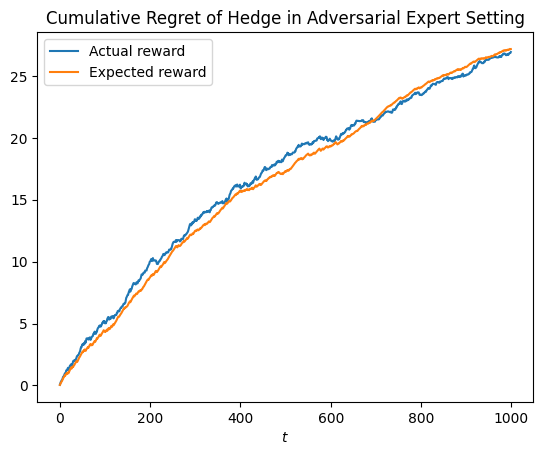

In [43]:
learning_rate = np.sqrt(np.log(K)/T) # we set the learning rate as prescribed by the theory


agent = HedgeAgent(K, learning_rate)
env = AdversarialExpertEnvironment(reward_sequence)

# best_arm = np.argmin(loss_seq.sum(axis=0))
# clairvoyant_losses = loss_seq[:, best_arm]

# we log to different cumulative losses for the agent
agent_reward = np.array([])
expected_agent_reward = np.array([])

for t in range(T):
    a_t = agent.pull_arm()
    r_t = env.round()
    agent.update(r_t)
    # logging
    agent_reward = np.append(agent_reward, r_t[a_t])
    expected_agent_reward = np.append(expected_agent_reward, np.dot(r_t, agent.x_t))

plt.plot(np.cumsum(clairvoyant_reward-agent_reward), label='Actual reward')
plt.plot(np.cumsum(clairvoyant_reward-expected_agent_reward), label='Expected reward')
plt.title('Cumulative Regret of Hedge in Adversarial Expert Setting')
plt.xlabel('$t$')
plt.legend()
plt.show()

In [44]:
print(f'Best arm in hindsight: {best_arm}')
print(f'Final allocation :{agent.x_t}') # the best arm is the one having more weight

Best arm in hindsight: 5
Final allocation :[9.76257451e-05 1.32904244e-03 1.06125805e-02 4.97062288e-02
 1.36555216e-01 2.20045979e-01 2.07982236e-01 1.31217806e-01
 8.19819544e-02 5.26158692e-02 3.42918080e-02 2.25391660e-02
 1.53914052e-02 1.07356682e-02 7.69021783e-03 5.64845445e-03
 4.19962822e-03 3.18078551e-03 2.37526870e-03 1.80306021e-03]


In [45]:
print(f'Theoretical bound: {2*np.sqrt(T*np.log(K))}')
print(f'Actual Total Regret {sum(clairvoyant_reward)-sum(agent_reward)}')
print(f'Expected Total Regret {sum(clairvoyant_reward)-sum(expected_agent_reward)}')

Theoretical bound: 109.46656610223947
Actual Total Regret 26.929542727642954
Expected Total Regret 27.16660820968012


Non truthfull auction

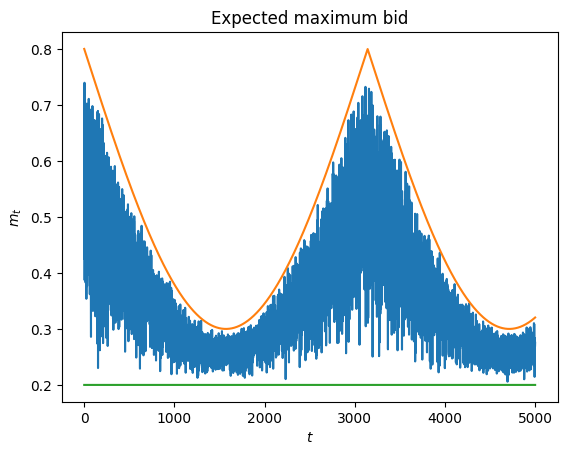

[0.     0.     0.     0.4124 0.7104 0.8804 0.9688 0.9982 1.     1.
 1.    ]


In [155]:
my_valuation = 1.5

### Adversarial Bidders
n_advertisers = 6
n_users = 5000  # T
K = 11          # K
B = 500         # budget
rho = B/n_users # budget per round
n_slots = 3     # number of slots

# non-trivial scenario: competitors sample bids from a uniform with range varying over time
pattern = lambda t: 0.8-np.abs(np.sin(5*t/n_users)/2)
other_bids = np.array([np.random.uniform(0.2, pattern(t), size = n_advertisers) for t in range(n_users)]).T
# I assume that competitors may have a larger budget than mine, but they may not deplete it.

# assuming all slots have the same prominence (probability of being clicked)
adv_ranking = np.sort(other_bids, axis=0)
m_t = adv_ranking[-n_slots]

plt.plot(m_t)
plt.plot([pattern(t) for t in range(n_users)])
plt.plot([0.2 for t in range(n_users)])
plt.title('Expected maximum bid')
plt.xlabel('$t$')
plt.ylabel('$m_t$')
plt.show()

available_bids = np.linspace(0,1,K)
win_probabilities = np.array([sum(b > m_t)/n_users for b in available_bids])
print(win_probabilities)

In [156]:
## Linear Program
c = -(my_valuation-available_bids)*win_probabilities
A_ub = [available_bids*win_probabilities]
b_ub = [rho]
A_eq = [np.ones(len(available_bids))]
b_eq = [1]
res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0,1))
gamma = res.x
print(gamma)
print(res.fun)
expected_clairvoyant_utilities = [-res.fun for u in range(n_users)]
print(expected_clairvoyant_utilities)
expected_clairvoyant_bids = [sum(available_bids*gamma*win_probabilities) for u in range(n_users)]

[0.19172325 0.         0.         0.80827675 0.         0.
 0.         0.         0.         0.         0.        ]
-0.39999999999999997
[0.39999999999999997, 0.39999999999999997, 0.39999999999999997, 0.39999999999999997, 0.39999999999999997, 0.39999999999999997, 0.39999999999999997, 0.39999999999999997, 0.39999999999999997, 0.39999999999999997, 0.39999999999999997, 0.39999999999999997, 0.39999999999999997, 0.39999999999999997, 0.39999999999999997, 0.39999999999999997, 0.39999999999999997, 0.39999999999999997, 0.39999999999999997, 0.39999999999999997, 0.39999999999999997, 0.39999999999999997, 0.39999999999999997, 0.39999999999999997, 0.39999999999999997, 0.39999999999999997, 0.39999999999999997, 0.39999999999999997, 0.39999999999999997, 0.39999999999999997, 0.39999999999999997, 0.39999999999999997, 0.39999999999999997, 0.39999999999999997, 0.39999999999999997, 0.39999999999999997, 0.39999999999999997, 0.39999999999999997, 0.39999999999999997, 0.39999999999999997, 0.39999999999999997, 0

In [157]:
class HedgeAgent:
    def __init__(self, K, learning_rate):
        self.K = K
        self.learning_rate = learning_rate
        self.weights = np.ones(K)
        self.x_t = np.ones(K)/K
        self.a_t = None
        self.t = 0

    def pull_arm(self):
        self.x_t = self.weights/sum(self.weights)
        self.a_t = np.random.choice(np.arange(self.K), p=self.x_t)
        return self.a_t

    def update(self, l_t):
        self.weights *= np.exp(-self.learning_rate*l_t)
        self.t += 1

In [158]:
class FFMultiplicativePacingAgent:
    def __init__(self, bids_set, valuation, budget, T, eta):
        self.bids_set = bids_set
        self.K = len(bids_set)
        self.hedge = HedgeAgent(self.K, np.sqrt(np.log(self.K)/T))
        self.valuation = valuation
        self.budget = budget
        self.eta = eta
        self.T = T
        self.rho = self.budget/self.T
        self.lmbd = 1
        self.t = 0

    def bid(self):
        if self.budget < 1:
            return 0
        return self.bids_set[self.hedge.pull_arm()]

    def update(self, f_t, c_t, m_t):
        # update hedge
        f_t_full = np.array([(self.valuation-b)*int(b >= m_t) for b in self.bids_set])
        c_t_full = np.array([b*int(b >= m_t) for b in self.bids_set])
        L = f_t_full - self.lmbd*(c_t_full-self.rho)
        range_L = 2+(1-self.rho)/self.rho
        self.hedge.update((2-L)/range_L) # hedge needs losses in [0,1]
        # update lagrangian multiplier
        self.lmbd = np.clip(self.lmbd-self.eta*(self.rho-c_t),
                            a_min=0, a_max=1/self.rho)
        # update budget
        self.budget -= c_t

In [159]:
class Auction:
    def __init__(self, *args, **kwargs):
        pass

    def get_winners(self, bids):
        pass

    def get_payments_per_click(self, winners, values, bids):
        pass

    def round(self, bids):
        winners, values = self.get_winners(bids) # allocation mechanism!
        payments_per_click = self.get_payments_per_click(winners, values, bids)
        return winners, payments_per_click


In [160]:
class FirstPriceAuction(Auction):
    def __init__(self, ctrs, n_slots):
        self.ctrs = ctrs
        self.n_adv = len(self.ctrs)
        self.n_slots = n_slots

    def get_winners(self, bids):
        adv_values = self.ctrs*bids
        adv_ranking = np.argsort(adv_values)
        winner = adv_ranking[-self.n_slots:]
        return winner, adv_values

    def get_payments_per_click(self, winners, values, bids):
        payment = values[winners]/self.ctrs[winners]
        return payment.round(2)

In [164]:
eta = 1/np.sqrt(n_users) # from theory
agent = FFMultiplicativePacingAgent(bids_set = available_bids,
                                    valuation=my_valuation,
                                    budget=B,
                                    T=n_users,
                                    eta=eta)

# assuming all advertisers have the same CTR
auction = FirstPriceAuction(np.ones(n_advertisers+1), n_slots)

utilities = np.array([])
my_bids = np.array([])
my_payments = np.array([])
total_wins = 0

np.random.seed(1)
for u in range(n_users):
    # interaction
    my_bid = agent.bid()
    bids = np.append(my_bid, other_bids[:, u].ravel())
    winners, payments_per_click = auction.round(bids=bids)
    print(winners)
    my_win = int(0 in winners)
    f_t, c_t = (my_valuation-m_t[u])*my_win, m_t[u]*my_win
    agent.update(f_t, c_t, m_t[u])
    # logging
    utilities = np.append(utilities, f_t)
    my_bids = np.append(my_bids, my_bid)
    my_payments = np.append(my_payments, c_t)
    total_wins+=my_win
print(f'Total # of Wins: {total_wins}')

[0 6 5]
[3 1 0]
[4 5 3]
[6 5 2]
[6 5 1]
[5 3 1]
[5 1 6]
[2 1 5]
[4 5 1]
[3 4 5]
[5 6 3]
[0 6 2]
[2 3 1]
[5 3 0]
[6 1 3]
[2 3 0]
[2 5 6]
[0 5 4]
[5 2 4]
[6 5 2]
[2 5 0]
[6 2 0]
[3 5 1]
[6 0 4]
[1 5 0]
[3 5 0]
[1 6 3]
[2 5 4]
[6 3 1]
[5 2 0]
[1 6 4]
[4 1 6]
[6 1 0]
[0 1 5]
[6 3 0]
[2 4 5]
[1 0 6]
[2 5 0]
[1 5 2]
[5 3 0]
[4 1 0]
[4 1 0]
[4 2 1]
[2 4 0]
[4 3 5]
[2 3 1]
[3 6 0]
[3 5 2]
[3 6 2]
[4 2 6]
[1 4 6]
[2 3 0]
[2 3 1]
[5 2 1]
[0 5 6]
[1 2 6]
[2 4 0]
[5 3 2]
[4 0 3]
[0 3 2]
[4 6 5]
[1 2 4]
[1 3 0]
[2 1 5]
[3 5 1]
[4 0 5]
[0 3 6]
[3 2 5]
[5 6 0]
[3 4 1]
[5 4 0]
[6 2 1]
[3 6 4]
[2 6 0]
[0 6 2]
[4 1 2]
[6 5 0]
[5 1 2]
[4 1 0]
[4 6 0]
[6 3 0]
[5 3 4]
[6 4 0]
[6 2 4]
[4 1 6]
[1 3 0]
[5 4 6]
[2 5 0]
[1 0 2]
[5 6 1]
[6 5 4]
[6 1 0]
[4 6 3]
[0 3 6]
[2 1 5]
[4 5 2]
[4 6 0]
[1 4 0]
[3 2 4]
[0 4 5]
[6 2 5]
[3 1 4]
[4 1 0]
[6 1 5]
[5 2 0]
[4 5 0]
[2 3 1]
[6 4 0]
[4 5 0]
[6 4 0]
[4 1 6]
[3 1 2]
[3 6 0]
[3 2 0]
[3 1 4]
[3 1 0]
[5 4 0]
[1 6 0]
[3 0 2]
[2 5 4]
[5 3 4]
[6 4 2]
[6 5 2]
[3 1 6]
[4 1 0]


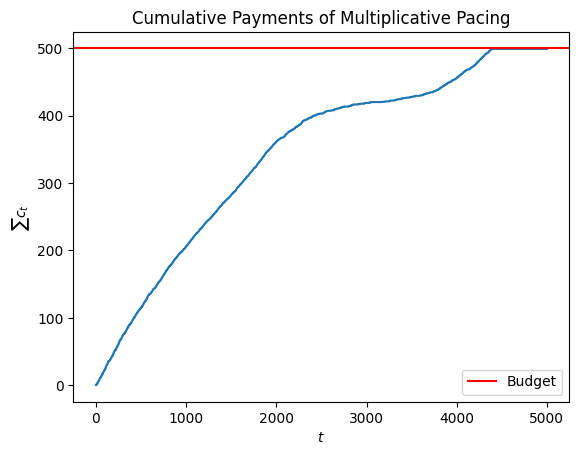

In [162]:
cumulative_payments = np.cumsum(my_payments)
plt.plot(cumulative_payments)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of Multiplicative Pacing')
plt.show()

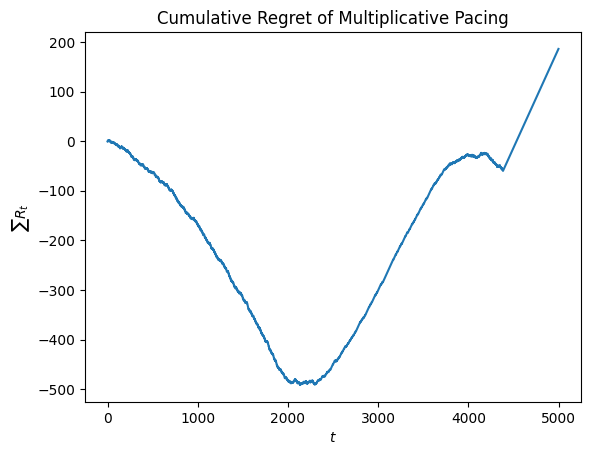

In [163]:
cumulative_regret = np.cumsum(expected_clairvoyant_utilities-utilities)
plt.plot(cumulative_regret)
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative Regret of Multiplicative Pacing')
plt.show()